In [1]:
%%time
import awkward
import uproot
input_file = uproot.open('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
base_awkward_array = input_file[input_file.keys()[0]].lazyarrays(namedecode='utf-8')
print(base_awkward_array)

{'eventNumber': <LazyArray 'eventNumber' at 7fa6041447f0>, 'eventCount': <LazyArray 'eventCount' at 7fa604144828>, 'runNumber': <LazyArray 'runNumber' at 7fa604144860>, 'lumiBlock': <LazyArray 'lumiBlock' at 7fa604144898>, 'backgroundFlags': <LazyArray 'backgroundFlags' at 7fa6041448d0>, 'eventWeight': <LazyArray 'eventWeight' at 7fa604144908>, 'pdfEventWeights': <LazyArray 'pdfEventWeights' at 7fa604144940>, 'pileupEventWeight': <LazyArray 'pileupEventWeight' at 7fa604144978>, 'xSecEventWeight': <LazyArray 'xSecEventWeight' at 7fa6041449b0>, 'actualIntPerCrossing': <LazyArray 'actualIntPerCrossing' at 7fa6041449e8>, 'averageIntPerCrossing': <LazyArray 'averageIntPerCrossing' at 7fa604144a20>, 'event_NCleanJets': <LazyArray 'event_NCleanJets' at 7fa604144ac8>, 'event_NJets': <LazyArray 'event_NJets' at 7fa604144a90>, 'event_HT': <LazyArray 'event_HT' at 7fa604144b00>, 'event_MHToHT': <LazyArray 'event_MHToHT' at 7fa604144b38>, 'event_HTMiss': <LazyArray 'event_HTMiss' at 7fa604144b70>,

In [2]:
import sys
sys.path.append('..')
from clientlib.DataSets import ArrayDataSet
real_awkward_dataset = ArrayDataSet('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
real_awkward_array_stream = real_awkward_dataset.AsAwkwardArray()

In [3]:
real_awkward_query = real_awkward_array_stream.Select('lambda e: (e.CalibJet_E, e.CalibJet_pT, e.CalibJet_eta, e.CalibJet_phi)')

In [4]:
%time output_array = real_awkward_query.value()

CPU times: user 25.8 ms, sys: 15 ms, total: 40.9 ms
Wall time: 5.11 s


In [5]:
output_array[0].size

120000

In [6]:
from math import asinh, atan2, hypot, pi, isinf, cosh, cos, sin, sinh, sqrt

def get_eta_from_pT_and_pz(pT, pz):
    if pT != 0:
        return asinh(pz / pT)
    elif pz == 0:
        return 0
    else:
        return float('infinity') * pz

class ThreeMomentum:
    def __init__(self, px, py, pz):
        self._px = px
        self._py = py
        self._pz = pz
        
    def __str__(self):
        return ('(' + str(self._px) + ', '
                    + str(self._py) + ', '
                    + str(self._pz) + ')')
    
    def px(self):
        return self._px
    
    def py(self):
        return self._py
    
    def pz(self):
        return self._pz
    
    def pT(self):
        return hypot(self._px, self._py)

    def eta(self):
        return get_eta_from_pT_and_pz(self.pT(), self._pz)
    
    def phi(self):
        return atan2(self._py, self._px)
        
    def __add__(self, other):
        return ThreeMomentum(self._px + other._px, self._py + other._py, self._pz + other._pz)

def get_smallest_radian_value(angle):
    while angle > pi:
        angle -= 2 * pi
    while angle < -pi:
         angle += 2 * pi
    return angle

class FourMomentum:
    def __init__(self, E, pT, eta, phi):
        if isinf(E) or E < pT or pT < 0:
            raise ValueError()
        if E == 0:
            if pT != 0:
                raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = float('nan')
            self._phi = float('nan')
        elif pT == 0:
            if not isinf(eta):
                raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = eta
            self._phi = float('nan')
        else:
            if isinf(eta) or isinf(phi):
                raise ValueError()
            if (pT * cosh(eta)) / E > 1.001:
                raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = eta
            self._phi = get_smallest_radian_value(phi)
            
    @classmethod
    def from_E_and_p3(cls, E, p3):
        return cls(E, p3.pT(), p3.eta(), p3.phi())
            
    def __str__(self):
        return (  'E = '   + str(self._E)   + ', '
                + 'pT = '  + str(self._pT)  + ', '
                + 'eta = ' + str(self._eta) + ', '
                + 'phi = ' + str(self._phi))
        
    def px(self):
        if self._pT == 0:
            return 0
        else:
            return self._pT * cos(self._phi)
    
    def py(self):
        if self._pT == 0:
            return 0
        else:
            return self._pT * sin(self._phi)
    
    def pz(self):
        if isinf(self._eta):
            raise NotImplementedError('Unable to calculate pz if pT = 0')
        else:
            return self._pT * sinh(self._eta)
        
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi

    def p3(self):
        return ThreeMomentum(self.px(), self.py(), self.pz())
    
    def __add__(self, other):
        new_E = self._E + other._E
        new_p3 = self.p3() + other.p3()
        return self.from_E_and_p3(new_E, new_p3)
        
    def p3_squared(self):
        return self.px() ** 2 + self.py() ** 2 + self.pz() ** 2
        
    def p3_magnitude(self):
        return sqrt(self.p3_squared())
    
    def m(self):
        return sqrt(self._E ** 2 - self.p3_squared())
        
def deltaEta(v1, v2):
    return v2.eta() - v1.eta()

def deltaPhi(v1, v2):
    return get_smallest_radian_value(v2.phi() - v1.phi())

def deltaR(v1, v2):
    return hypot(deltaEta(v1, v2), deltaPhi(v1, v2))

E = 209.45963567695793, pT = 85.585328125, eta = -1.5411477088928223, phi = 1.5399823188781738
E = 50.8569008621466, pT = 30.156796875, eta = 1.1030752658843994, phi = -1.7798477411270142
E = 38.23670360942477, pT = 27.329365234375, eta = -0.8471185564994812, phi = 1.7790178060531616
E = 23.43329205292181, pT = 22.639572265625, eta = -0.12941420078277588, phi = 0.2987922728061676
E = 34.08531686173584, pT = 21.113765625, eta = 1.0522892475128174, phi = 2.3908755779266357
E = 21.40224822199898, pT = 19.114765625, eta = -0.43428581953048706, phi = 1.3274266719818115
E = 18.774834928534673, pT = 17.340818359375, eta = -0.35882750153541565, phi = -2.048685312271118
E = 17.40520495450177, pT = 16.1868828125, eta = 0.33463695645332336, phi = -1.041507601737976
E = 112.48712674839861, pT = 14.7517900390625, eta = 2.7202939987182617, phi = -1.0640367269515991
E = 117.02456782852232, pT = 113.56140625, eta = 0.2306176722049713, phi = 0.5579949021339417
E = 44.1294887862493, pT = 43.05083984375,

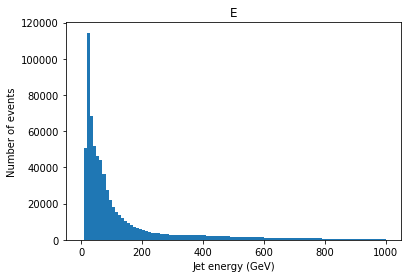

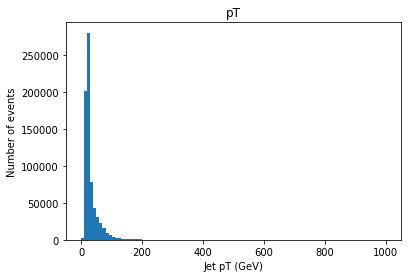

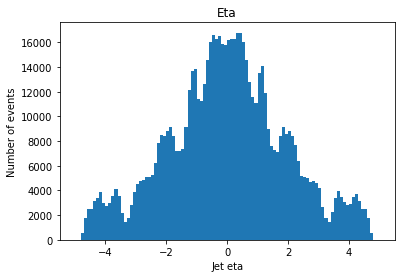

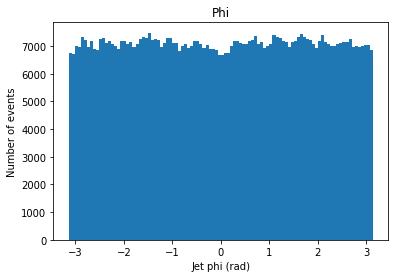

In [8]:
import matplotlib.pyplot as plt
n = 0
for event_arrays in zip(output_array[0], output_array[1], output_array[2], output_array[3]):
    for jet_properties_tuple in zip(event_arrays[0], event_arrays[1], event_arrays[2], event_arrays[3]):
        E = jet_properties_tuple[0]
        pT = jet_properties_tuple[1]
        eta = jet_properties_tuple[2]
        phi = jet_properties_tuple[3]
        p4 = FourMomentum(E, pT, eta, phi)
        if n < 100:
            print(p4)
        n += 1

plt.hist(output_array[0].flatten(), 100, (0,1000))
plt.title('E')
plt.xlabel('Jet energy (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(output_array[1].flatten(), 100, (0,1000))
plt.title('pT')
plt.xlabel('Jet pT (GeV)')
plt.ylabel('Number of events')
plt.show()

plt.hist(output_array[2].flatten(), 100, (-5,5))
plt.title('Eta')
plt.xlabel('Jet eta')
plt.ylabel('Number of events')
plt.show()

plt.hist(output_array[3].flatten(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('Jet phi (rad)')
plt.ylabel('Number of events')
plt.show()